# R68 Yield Fitting
This notebook is meant to bring together all the R68 simulations and measurements in order to extract an estimate of the NR yield function

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np
import pandas as pd

../mplstyles
3.0.3
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


# Measured Data
Load in measured data for PuBe and Bkg

In [3]:
fpube = open('data/r68_n125_PuBe_cgood_final_PTOFkeV_2keV_scan_fmt.txt')
fbknd = open('data/r68_n125_bkg_cgood_final_PTOFkeV_2keV_scan_fmt.txt')

d = np.asarray([x.split() for x in fpube.readlines()],dtype=np.float)
db = np.asarray([x.split() for x in fbknd.readlines()],dtype=np.float)

fpube.close()
fbknd.close()

#Measured event energies in keV for PuBe (dE) and background (dbE)
E_PuBe = d[:,1]
E_Bkg = db[:,1]
print(np.shape(E_PuBe))
print(np.shape(E_Bkg))

#TODO:
#Measured data live time estimates
#https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_68:run_68_rateandlivetime#iii_read_efficiency
tlive_PuBe = 97.9*3600 #[s]
#tlive_bkg = tlive_PuBe*193/640 # Naive scaling by number of series
tlive_bkg = 24.1*3600 #[s]

(480634,)
(174510,)


## Simulation Data Skims

We'll use several skims of the full simulation data with cuts to select different interactions. The sims are done with commands like

```./sima2py.py --regex 'Run68_gdirect_bknd_R68_PuBe_0x0006_10M_1550\S+.txt' --filedir /data/chocula/villaa/k100Sim_Data/captureCal/ --outfile /data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_cap.h5 --cuts NRc```

These skims only contain a some (2716) of all the simulated data files. The outputs are located in `/data/chocula/villaa/k100Sim_Data/captureCalhdf5/`:

| File                                          | Description  |
| :---                                          |    :---:     |
| `R68_gdirect_testskim_superhighstat_nocap.h5` | NR, No capture   |
| `R68_gdirect_testskim_superhighstat_nocap_er_lowe.h5` | ER, No capture   |


Nick did skims of the full set of simulated data using the flag: ```--regex 'Run68_gdirect_bknd_R68_PuBe_0x0006_10M_155\S+.txt'``` with the sima2py in the git hash: f0c2a47. These skims use the full set of 40261 G4 output files.

The resulting skims are located in `/home/mast/cdms/analysis/run068/simulations/k100_ncapture_cal/data/`:

| File                                          | Description  |
| :---                                          |    :---:     |
| `R68_gdirect_testskim_stupidhighstat_nocap_nr.h5` | NR, No capture   |
| `R68_gdirect_testskim_stupidighstat_nocap_er_lowe.h5` | ER, No capture   |

Some of the 40261 G4 output files are incomplete (missing lines, values, etc.) These are simply skipped in the skim. There are 932 such files as can be seen by counting the 'Incomplete' labels in the output of sima2py, such as in the file ```R68_gdirect_testskim_stupidhighstat_nocap_er_lowe_skimfiles.txt```. This leaves 39329 files which were actually included.

In [5]:
#===============to suppress h5py warning see:
#https://github.com/h5py/h5py/issues/961
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()

#f_nr_nocap = h5py.File("/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_nocap.h5","r")
f_nr_nocap = h5py.File("data/R68_gdirect_testskim_stupidhighstat_nocap_nr.h5","r")
data_nr_nocap = f_nr_nocap['geant4/hits']

#f_er_nocap = h5py.File("/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_nocap_er_lowe.h5","r")
f_er_nocap = h5py.File("data/R68_gdirect_testskim_stupidhighstat_nocap_er_lowe.h5","r")
data_er_nocap = f_er_nocap['geant4/hits']

print(np.shape(data_nr_nocap))
print(np.shape(data_er_nocap))

#https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_68:run_68_n125:full_signal_fit&#efficiencies_and_live_time
tlive_g4 = 18.9*3600 #s

(528848, 7)
(129555, 7)


In [6]:
#now make a dataframe with the restricted data
#Columns are:
#cols=['EV', 'DT', 'TS', 'P', 'Type', 'E1', 'D3', 'PX3', 'PY3', 'PZ3', 'X3', 'Y3', 'Z3',
#      'time3', 'PX1', 'PY1', 'PZ1', 'X1', 'Y1', 'Z1', 'time1', 'nCap']

cols=['EV', 'D3', 'X3', 'Y3', 'Z3','time3', 'nCap']

sel_names=['EV', 'D3', 'X3', 'Y3', 'Z3', 'time3', 'nCap']#Select these variables
sel=[cols.index(i) for i in sel_names]

nr_nocap_data = data_nr_nocap[:,sel]
nr_nocap_dataframe = pd.DataFrame(data=nr_nocap_data, columns=sel_names)
er_nocap_data = data_er_nocap[:,sel]
er_nocap_dataframe = pd.DataFrame(data=er_nocap_data, columns=sel_names)

#need unique event numbers in case of (rare) duplicate 'EV's
nr_nocap_evnew=np.cumsum(np.diff(nr_nocap_data[:,0],prepend=nr_nocap_data[0,0]).astype(bool).astype(float))
nr_nocap_dataframe.insert(0,'EVnew',nr_nocap_evnew)

er_nocap_evnew=np.cumsum(np.diff(er_nocap_data[:,0],prepend=er_nocap_data[0,0]).astype(bool).astype(float))
er_nocap_dataframe.insert(0,'EVnew',er_nocap_evnew)

In [7]:
##Group hits into vectors for each thrown event
#These loops can take a while

groupbyvec=['EVnew']

#NR, no capture
max_vec_nr_nocap = np.max(nr_nocap_dataframe.groupby(groupbyvec,axis=0).size())
vec0_nr_nocap = np.zeros((1,max_vec_nr_nocap))

evec_nr_nocap = np.zeros((0,max_vec_nr_nocap))#Hit energies
nhit_nr_nocap = np.zeros((0,1))#Number of hits

nr_nocap_grouped=nr_nocap_dataframe.groupby(groupbyvec).agg({'D3':list})
for d3 in nr_nocap_grouped.D3:
    d3i=vec0_nr_nocap.copy()
    d3i[0,0:np.shape(d3)[0]] = np.transpose(np.asarray(d3))
    evec_nr_nocap = np.append(evec_nr_nocap,d3i*1e6,0) #convert from MeV to eV
    nhit_nr_nocap = np.append(nhit_nr_nocap,np.shape(d3)[0])
    
#ER, no capture
max_vec_er_nocap = np.max(er_nocap_dataframe.groupby(groupbyvec,axis=0).size())
vec0_er_nocap = np.zeros((1,max_vec_er_nocap))

evec_er_nocap = np.zeros((0,max_vec_er_nocap))#Hit energies
nhit_er_nocap = np.zeros((0,1))#Number of hits

er_nocap_grouped=er_nocap_dataframe.groupby(groupbyvec).agg({'D3':list})
for d3 in er_nocap_grouped.D3:
    d3i=vec0_er_nocap.copy()
    d3i[0,0:np.shape(d3)[0]] = np.transpose(np.asarray(d3))
    evec_er_nocap = np.append(evec_er_nocap,d3i*1e6,0) #convert from MeV to eV
    nhit_er_nocap = np.append(nhit_er_nocap,np.shape(d3)[0])

## Simulated Capture Data
(Text and code adapted from SiCaptureSpectrum)

In order to assess the expected signal in a capture experiment that could be run at UMN, Anthony simulated silicon capture cascades in the correct ratios according to the isotopic abundance and probabilities of specific cascades.

He modeled the 47 most important cascades for silicon as accurately as possible.  Information about the capture probabilities has come from [this paper][SiCascade].  Knowledge of the level lifetimes has generally come from [Brookhaven National Lab's interactive chart of the nuclides][nndc].

[SiCascade]: https://journals.aps.org/prc/abstract/10.1103/PhysRevC.46.972 "Si Capture Reference"
[nndc]: https://www.nndc.bnl.gov/chart/ "Interactive Chart of the Nuclides"

Some lifetimes require estimation because they are unknown.  In these cases Anthony used an [empirical relation][WeissCalc] based on the [Weisskopf estimates][WeissEst] for the lifetimes of nuclear states given the multipolarity of their decays.  He often use the shorthand "fast" or "slow" estimates, this means that for a given level he would either use the allowed multipolarity that gives the shortest transition lifetime (fast estimate) or the allowed multipolarity that would give the longest transition time (slow estimates). 

[WeissCalc]: https://www.sciencedirect.com/science/article/pii/S0550306X66800113 "Definition of Weisskopf Units"
[WeissEst]: https://journals.aps.org/pr/abstract/10.1103/PhysRev.83.1073 "Phys. Rev. 1951 Paper of Weisskopf Estimate"

Slow transitions generally result in more well-resolved peaks because the recoiling excited state has time to deposit all of its energy before recoiling off of another gamma.  In that case the sum of the recoil energies is constant in a given cascade.  If any of the decays happen "in flight" then the recoils may not deposit all of their energies and can smear the spectrum.  It is tacitly assumed that all gammas will leave the volume _without_ interacting.  This is a very good approximation for a small detector. 

Let's load up some simulated cascade data. 

In [8]:
import pickle as pkl
lifetimes='fast'
Ncascades='200k' #'2M' or '200k'

#load up some cascade simulated data; 20k cascade events
with open('/data/chocula/villaa/cascadeSimData/normsi_{0}_{1}.pkl'.format(lifetimes, Ncascades),'rb') as readFile:
      cdata=pkl.load(readFile,encoding='latin1')

print(cdata.keys())
print(cdata['totalevents'])

#https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_68:run_68_n125:full_signal_fit&#efficiencies_and_live_time
tlive_ng = cdata['totalevents']/0.218 #[s]

dict_keys(['delE', 'E', 'cid', 'I', 'Eg', 'totalevents', 'n', 'taus', 'Ei', 'Elev', 'time', 'cEscape'])
200000


Each of the keys in the associated dictionary is linked to a [NumPy][numpy] data structure with structure and meaning as listed in the table below. 

[numpy]: http://www.numpy.org/ "NumPy"

key name|NumPy structure|Description 
:-|:-|:-
totalevents|integer value|total number of simulated cascades
n|integer array with shape (totalevents,)|number of steps in cascade
cid|integer array with shape (totalevents,)|identifier for specific cascade based on simulation input
Elev|double array with shape (totalevents,n)|level energy after each recoil in keV
taus|double array with shape (totalevents,n)|lifetime of each level in fs
E|double array with shape (totalevents,n)|energy of recoiling ion at the beginning of each "step" in eV
delE|double array with shape (totalevents,n)|energy deposited at each step in eV
I|integer array with shape (totalevents,n)|ionization according to Lindhard model for each step in e/h pairs
Ei|double array with shape (totalevents,n)|effective ionization in electron-equivalent energy for each step in eV$_{ee}$
time|double array with shape (totalevents,n)|absolute time relative to capture time of decay of this step in fs
Eg |double array with shape (totalevents,n)|gamma energy modifying this step's recoil in MeV
cEscape |boolean array with shape (totalevents,)|True if all the gammas escaped the detector without interacting

## The Expected Capture Spectrum

Since the capture events consist mostly of composite nuclear recoils, we must decide how to account for the ionization yield correctly for each cascade step.  Assume a nuclear recoil created by a cascade step begins at energy $E_0$ and deposits energy $\delta E$ in the step. We would then expect the ionization to be that which would have been given from a deposited energy of $E_0$ less that which would have been given from a deposit of $E_0 - \delta E$.  This simply assumes that the ionization is independent of the slowing-down history of the particle, or, that any recoil of energy $E$ will give a reproducible amount of ionization regardless of the circumstances of its creation.

This means that the amount of ionization energy in a given step, i, is

$E_{ion,i} = E_{0,i}Y(E_{0,i}) - (E_{0,i}-\delta E_i)Y(E_{0,i}-\delta E_i)$

and the total number created in an event is simply: $N_{tot} = \sum N_i = \sum \frac{E_{ion,i}}{\varepsilon}$

Similarly, we will assume that the variance of each step is: $\sigma_i^2 = F_{NR}N_i$ and that hits are uncorrelated so that the total variance of the event is $\sigma_{tot}^2 = \sum \sigma_i^2 $ so that, for an energy-independent Fano factor, we have $\sigma_{tot}^2=F_{NR}N_{tot}$.

## Yield and resolution
For each event we need to apply some yield and Fano factor. We also apply a resolution function. 

### Calculations are done as follows:

#### ER
1. Sum deposited hit energies to get total recoil energy, E_recoil
2. Apply Fano to total recoil energy
3. Calculate Eee = E_recoil*(1+YV/eps)/(1+V/eps)
4. Apply resolution function (not including Fano contribution) to E_ee.

#### NR, (n,gamma)
1. Get ER energy deposited from each hit
2. Apply Fano to each hit to get N
3. E_NTL + E_recoil to get Etot for each hit
4. Sum Etot for each event
5. Convert to E_ee by dividing out G_NTL = 1+V/eps
6. Apply resolution function (not including Fano contribution) to E_ee.

In [9]:
import damic_y as dy 

#a spline extrapolation to DAMIC data
damic_y = dy.getDAMICy()
damic_yv = np.vectorize(damic_y) #vectorize it

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [10]:
from random import choices
from scipy.special import erf

V = 125 #R68 bias voltage
eps = 3.8 #eV for silicon
Eg = 1.12 #eV bandgap
G_NTL = (1+(V/eps)) #NTL gain
F = 0.1161 #silicon value taken from https://www.sciencedirect.com/science/article/pii/S0168900297009650

#Some yield model
def Yield(Er, par):
    #return par[0]+(par[1]-par[0])/(1+par[2]/Er)
    #return damic_y(Er)
    return yL(Er, par[0])
    #return ySorCon(Er, par[0], par[1])
    #return yChav(Er, par[0], par[1])
    
#Lindhard yield
#http://gymarkiv.sdu.dk/MFM/kdvs/mfm%2030-39/mfm-33-10.pdf
#k = 0.133Z^(2/3)A^(−1/2)
#This is only decent for eps>0.01 => Er>400 eV
def yL(Er, k):
    Z=14.
    eps = 11.5*Er/1000*Z**(-7./3)
    g = 3.*eps**0.15 + 0.7*eps**0.6 + eps
    return (k*g)/(1+k*g)

#Lindhard w/ Chavarria tweak
#https://arxiv.org/pdf/1803.02903.pdf
def yChav(Er,k,a):
    return 1/(1/(a*Er)+1/yL(Er,k))

#Sorenson: Lindhard + constant
#https://journals.aps.org/prd/pdf/10.1103/PhysRevD.91.083509
def ySorCon(Er,k,q):
    Z=14.
    eps = 11.5*Er/1000*Z**(-7./3)
    #This can go negative for large q/eps
    return np.maximum(0,yL(Er,k)-q/eps)

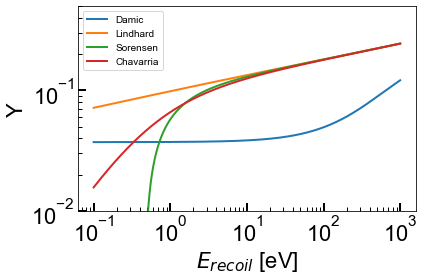

In [11]:
plt.figure()
E_test=np.logspace(-1,3,1000)
plt.plot(E_test,damic_y(E_test),label='Damic')
plt.plot(E_test,yL(E_test,0.179),label='Lindhard')
plt.plot(E_test,ySorCon(E_test,0.179,1e-6),label='Sorensen')
plt.plot(E_test,yChav(E_test,0.179,0.2),label='Chavarria')

plt.gca().set_xlabel(r'$E_{recoil}$ [eV]')
plt.gca().set_ylabel('Y')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_ylim(1e-2,0.5)

plt.legend()
plt.tight_layout()
#plt.savefig('figures/R68_Y_fit/Ytest1.png')


In [12]:
  
#N e/h pairs function
#simplistic gaussian model for charge to get width and mean correct
#discretize a normal distribution, don't allow negative N
def getNeh(E,eps,F):
    #TMP
    #return np.random.normal((E/eps),np.sqrt(F*(E/eps)),np.shape(E))
    N=np.round(np.random.normal((E/eps),np.sqrt(F*(E/eps)),np.shape(E)))
    return np.maximum(0,N)

#Resolution functions

#Detector Resolution function
def sigma_ee(E,sigma0,B,A):
    return np.sqrt(sigma0**2 + B*E + (A*E)**2)

#Draw a value from the resolution distribution
#Option to include effect of OF bias at low energies
def getSmeared(E, doLowEbias=False):
    #Params from Matt's Bkg resolution fit:
    #https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_68:run_68_panda:calibration#resolution_versus_energy
    sigma0=10.27 #eV 
    B=0.627*3.8 #This includes FANO
    B_1=B-F*eps
    A=0 #TODO: This part has not been fit yet!

    #Ignore low energy bias for faster execution
    if not doLowEbias:
        return np.random.normal(E,sigma_ee(E,sigma0,B_1,A),np.shape(E))
    else:
        #Low energy OF bias
        #From Nick's fit to PuBe noise wall
        N=3.83

        Esmeared=np.array([])
        for Ei in E:
            s_ee=sigma_ee(Ei,sigma0,B,A)
            vals=np.linspace(Ei-5*s_ee,Ei+5*s_ee,100)
            weights=P_OF_max(vals,Ei,s_ee,N)
            Esmeared=np.append(Esmeared,choices(vals, weights)[0])
        return Esmeared

#OF resolution function
#Returns probability of Ahat given A and N indpendent bins when selecting the max Ahat
#See http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/OF_bias_theory.html
def P_OF_max(Ahat,A,sigma,N):
    term1=P_OF0(Ahat,A,sigma)*(0.5+0.5*erf(Ahat/np.sqrt(2)/sigma))**(N-1)
    term2A=(N-1)*P_OF0(Ahat,0,sigma)*(0.5+0.5*erf(Ahat/np.sqrt(2)/sigma))**(N-2)
    term2B=0.5+0.5*erf((Ahat-A)/np.sqrt(2)/sigma)
    return term1+term2A*term2B

#PDF for OF0
def P_OF0(Ahat,A,sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(Ahat-A)**2/2/sigma**2)

## Efficiencies
Trigger efficiency is the result of triggering on simulated event distributions.

Cut efficiencies are estimated from the data.

In [13]:
#Trigger efficiency
#Note, this is a function of true pulse energy, before OF resolution effects
fefftrig = open('data/r68_trigger_eff_1keV.txt')
data_efftrig = np.asarray([x.split() for x in fefftrig.readlines()[1:]],dtype=np.float)
fefftrig.close()

def trigEff(E):
    #https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_68:run_68_trigger
    #v3
    #return erf(E/(np.sqrt(2.)*30.86))
    #v4
    #return 1-np.exp(-((E/57.3015)**1.07219))

    #Final
    return np.interp(E,data_efftrig[:,0],data_efftrig[:,1])
    
#Return uncertainties on the trigger efficiency.
#These come from the stdev across multiple trigger sims which dominated statistical uncertainties in a given sim
def dtrigEff(E):
    return np.interp(E,data_efftrig[:,0],data_efftrig[:,2])


#Cut Efficiencies
eff_write = 0.617 #https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_68:run_68_rateandlivetime#iii_read_efficiency
deff_write = 0.004
eff_tail = 0.8197 #http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Run68_CutEff_1/
deff_tail = 0.0013
eff_pileup = 0.9651 #http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Run68_CutEff_2/
deff_pileup = 0.0013
eff_trigburst = 0.9887 #http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Run68_RateCut_pt2/
deff_trigburst = 0.0013 #Estimated from the out-of band passage which has uncertainty ~sqrt(2/N) and N~1.2e6

#Spikey Cut Efficiency
feffspike = open('data/r68_cspike_eff_1keV.txt')
data_effspike = np.asarray([x.split() for x in feffspike.readlines()[1:]],dtype=np.float)
feffspike.close()

def spikeEff(E):
    #http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Run68_SpikeEff/
    return np.interp(E,data_effspike[:,0],data_effspike[:,1])

#Return upper and lower spike cut uncertainties
def dspikeEff(E):
    dup = np.interp(E,data_effspike[:,0],data_effspike[:,2])
    dlow = np.interp(E,data_effspike[:,0],data_effspike[:,3])
    return np.stack((dup,dlow))

#Chisq Cut Efficiency
feffchi = open('data/r68_cchit_eff_1keV.txt')
data_effchi = np.asarray([x.split() for x in feffchi.readlines()[1:]],dtype=np.float)
feffchi.close()

def chisqEff(E):
    #v1
    #eff_chisq = 0.645 #http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Run68_CutEff_2/
    
    #v2 w/Energy dependence
    #http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Run68_CutEff_2/
    return np.interp(E,data_effchi[:,0],data_effchi[:,1])

#Return upper and lower chisq cut uncertainties
def dchisqEff(E):
    dup = np.interp(E,data_effchi[:,0],data_effchi[:,2])
    dlow = np.interp(E,data_effchi[:,0],data_effchi[:,3])
    return np.stack((dup,dlow))

#Return the total cut efficiency curve
def cutEff(E):
    return eff_write*eff_tail*eff_pileup*eff_trigburst*spikeEff(E)*chisqEff(E)

#Return the upper and lower total cut uncertainties
#Adding asymm errors in quadrature is apparently naughty (https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf)
#But they're not that asymmetric, so it's probably fine
def dcutEff(E):
    eff_write*eff_tail*eff_pileup*eff_trigburst*spikeEff(E)*chisqEff(E)
    
    dupsq = (deff_write/eff_write)**2 + (deff_tail/eff_tail)**2 + (deff_pileup/eff_pileup)**2 + \
    (deff_trigburst/eff_trigburst)**2 + (dspikeEff(E)[0]/spikeEff(E))**2 (dchisqEff(E)[0]/chisqEff(E))**2
    dup = np.sqrt(dupsq)
    
    dlowsq = (deff_write/eff_write)**2 + (deff_tail/eff_tail)**2 + (deff_pileup/eff_pileup)**2 + \
    (deff_trigburst/eff_trigburst)**2 + (dspikeEff(E)[1]/spikeEff(E))**2 (dchisqEff(E)[1]/chisqEff(E))**2
    dlow = np.sqrt(dlowsq)
    
    return np.stack((dup,dlow))


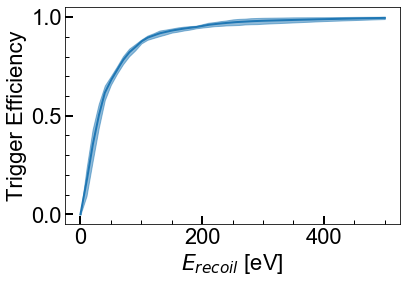

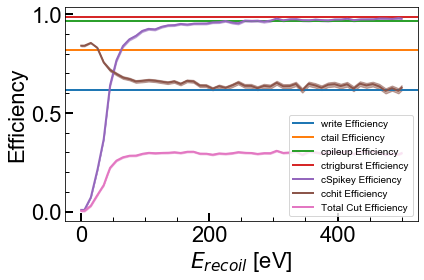

In [14]:
E_test=np.linspace(0,5e2,1000)
fig,ax = plt.subplots(1,1)
ax.plot(E_test,trigEff(E_test),color='C0')
ax.fill_between(E_test,trigEff(E_test)-dtrigEff(E_test),trigEff(E_test)+dtrigEff(E_test),alpha=0.5,color='C0')

ax.set_xlabel(r'$E_{recoil}$ [eV]')
ax.set_ylabel('Trigger Efficiency')

fig,ax = plt.subplots(1,1)
ax.axhline(eff_write, color = next(ax._get_lines.prop_cycler)['color'], label='write Efficiency')
ax.axhspan(eff_write-deff_write, eff_write+deff_write, alpha=0.5)

ax.axhline(eff_tail, color = next(ax._get_lines.prop_cycler)['color'], label='ctail Efficiency')
ax.axhspan(eff_tail-deff_tail, eff_tail+deff_tail, alpha=0.5)

ax.axhline(eff_pileup, color = next(ax._get_lines.prop_cycler)['color'], label='cpileup Efficiency')
ax.axhspan(eff_pileup-deff_pileup, eff_pileup+deff_pileup, alpha=0.5)

ax.axhline(eff_trigburst, color = next(ax._get_lines.prop_cycler)['color'], label='ctrigburst Efficiency')
ax.axhspan(eff_trigburst-deff_trigburst, eff_trigburst+deff_trigburst, alpha=0.5)

line,=ax.plot(E_test, spikeEff(E_test), label='cSpikey Efficiency')
ax.fill_between(E_test, spikeEff(E_test)-dspikeEff(E_test)[1], spikeEff(E_test)+dspikeEff(E_test)[0], 
                alpha=0.5, color=line.get_color())

line,=ax.plot(E_test,chisqEff(E_test), label='cchit Efficiency')
ax.fill_between(E_test, chisqEff(E_test)-dchisqEff(E_test)[1], chisqEff(E_test)+dchisqEff(E_test)[0], 
                alpha=0.5, color=line.get_color())

line,=ax.plot(E_test, cutEff(E_test), label='Total Cut Efficiency')
ax.fill_between(E_test, cutEff(E_test)-cutEff(E_test)[1], cutEff(E_test)+cutEff(E_test)[0], 
                alpha=0.5, color=line.get_color())
ax.set_xlabel(r'$E_{recoil}$ [eV]')
ax.set_ylabel('Efficiency')
ax.legend()
plt.tight_layout()
#plt.savefig('figures/R68_Y_fit/cut_effs.png')

In [15]:
#Select energies according to trigger efficiency
#Return whether energies passed the trigger
def passTrig(E):
    return np.random.random(E.shape)<trigEff(E)

In [16]:
#Apply yield, resolution, efficiencies etc. to simulated data to get an instance of a simulated E_ee spectrum

#Ypar: Yield function parameters passed to Yield() function defined above
#F_NR: Nuclear recoil Fano factor
#fng_scale: (n,gamma) spectrum scaling factor
#fnrer_scale: Scaling of NR+ER sim spectrum
#doDetRes: whether to apply detector resolution function

def buildSpectra(Ypar, F_NR, fng_scale=1, fnrer_scale=1, doDetRes=True):
    #fudge = (n,gamma) rate normalization
    global evec_nr_nocap
    global evec_er_nocap
    global cdata
    
    global E_PuBe
    global E_Bkg
    
    ###############
    #Yield, Fano, Resolution
    ###############
    #NR, No capture
    Evec_nr_nocap_er = evec_nr_nocap*Yield(evec_nr_nocap,Ypar) #ER energy from NRs
    
    #Number of e/h pairs produced in each event
    Nvec_nr_nocap = getNeh(Evec_nr_nocap_er,eps,F_NR)
    #get the total phonon energies
    Etvec_nr_nocap = evec_nr_nocap + Nvec_nr_nocap*V
    #Sum event and convert to eVee scale by making the gamma assumption
    Eee_nr_nocap  = np.sum(Etvec_nr_nocap,1)/G_NTL
    
    #Apply trigger logic to randomly drop events according to their energies
    Eee_nr_nocap = Eee_nr_nocap[passTrig(Eee_nr_nocap)]
    
    if doDetRes:
        Eee_nr_nocap = getSmeared(Eee_nr_nocap)#add resolution
    #print('Eee_nr_nocap[:10]',Eee_nr_nocap[:10])
    #print('Eee_nr_nocap.shape:',Eee_nr_nocap.shape)
    #print('Eee_nr_nocap[Eee_nr_nocap*Y<2000].shape:',Eee_nr_nocap[Eee_nr_nocap*Y<2000].shape)

    #ER, No capture
    #Number of e/h pairs produced in event
    E_er_nocap_er = np.sum(evec_er_nocap,1) #ER energy from ERs
    N_er_nocap = getNeh(E_er_nocap_er,eps,F)
    #get the total phonon energy
    Et_er_nocap = N_er_nocap*V + E_er_nocap_er
    #convert to eVee scale
    Eee_er_nocap  = Et_er_nocap/G_NTL
    
    #Apply trigger logic to randomly drop events according to their energies
    Eee_er_nocap = Eee_er_nocap[passTrig(Eee_er_nocap)]
    
    if doDetRes:
        Eee_er_nocap = getSmeared(Eee_er_nocap)#add resolution
    #print('Eee_er_nocap[:10]',Eee_er_nocap[:10])
    #print('Eee_er_nocap.shape:',Eee_er_nocap.shape)
    #print('Eee_er_nocap[Eee_er_nocap<2000].shape:',Eee_er_nocap[Eee_er_nocap<2000].shape)
    
    #Convert Simulated n,gamma hits to eVee events
    #Select only events where the gamma escapes. Assume the rest end up at high eVee
    #Prepare for the computation
    E_ng = cdata['E'][cdata['cEscape']]
    dE_ng = cdata['delE'][cdata['cEscape']]
    E_ng_er = E_ng*Yield(E_ng,Ypar) - (E_ng-dE_ng)*Yield(E_ng-dE_ng,Ypar)
    #print('E_ng_er.shape:',E_ng_er.shape)
        
    #simplistic gaussian model for charge to get width and mean correct
    N_ng = getNeh(E_ng_er,eps,F_NR)

    #get the total phonon energy
    Et_ng_step = N_ng*V + dE_ng
    Et_ng = np.sum(Et_ng_step,1)

    #convert to eVee scale by making the gamma assumption
    Eee_ng  = Et_ng/G_NTL
    
    #Apply trigger logic to randomly drop events according to their energies
    Eee_ng = Eee_ng[passTrig(Eee_ng)]
    
    if doDetRes:
        Eee_ng = getSmeared(Eee_ng) #add resolution
    #print('Eee_ng[:10]',Eee_ng[:10])
    #print('Eee_ng.shape:',Eee_ng.shape)
    #print('Eee_ng[Eee_ng*Y<2000].shape:',Eee_ng[Eee_ng*Y<2000].shape)
    ###############
    #Binning
    ###############
    Emax = 2000 #eVee
    Ebins=np.linspace(0,Emax,201)
    Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

    #Measured
    n_E_PuBe,_ = np.histogram(E_PuBe*1e3,bins=Ebins)
    n_E_Bkg,_ = np.histogram(E_Bkg*1e3,bins=Ebins)

    #Simulated
    n_Eee_nr_nocap,_ = np.histogram(Eee_nr_nocap,bins=Ebins)
    n_Eee_er_nocap,_ = np.histogram(Eee_er_nocap,bins=Ebins)
    n_Eee_ng,_ = np.histogram(Eee_ng,bins=Ebins)

          
    #print('sum(n_Eee_nr_nocap):',np.sum(n_Eee_nr_nocap))
    #print('sum(n_Eee_er_nocap):',np.sum(n_Eee_er_nocap))
    #print('sum(n_Eee_ng):',np.sum(n_Eee_ng))
    
    ###############
    #Livetime, efficiencies, etc.
    ###############
    
    #Livetime
    N_er = n_Eee_er_nocap/tlive_g4
    N_nr = n_Eee_nr_nocap/tlive_g4
    N_ng = n_Eee_ng/tlive_ng
    N_PuBe = n_E_PuBe/tlive_PuBe
    N_bkg = n_E_Bkg/tlive_bkg
    
    eff_cuts = cutEff(Ebin_ctr)
    
    #Apply these to the simulated data
    N_er = N_er*eff_cuts*fnrer_scale
    N_nr = N_nr*eff_cuts*fnrer_scale
    N_ng = N_ng*eff_cuts*fng_scale
    
    return (Ebins, N_er, N_nr, N_ng, N_PuBe, N_bkg)

# Averaged spectra
Here we calculate the average simulated spectra instead of a single instance of the simulated spectra. This can be achieved by either averaging a large number of simulated spectra with the same Y, F_NR, etc. or by smearing each simulated event with the resolution functions. The mean, electron-equivalent energy, for a recoil of energy Er is:

$<E_{ee}> = (E_r + Y*E_r/\epsilon*V)/G_{NTL} = E_r\frac{1 + Y*V/\epsilon}{1+V/\epsilon}$

and the width is (http://www.hep.umn.edu/cdms/cdms_restricted/K100/analysis/Peak_Widths.pdf):

$\sigma_{ee}^2 = E_{ion} \frac{FV^2}{\epsilon}/(1 + V/\epsilon)^2$

The ER hits in a given 'EV' are all considered part of the same event, which deposited some total recoil energy, Er, which is the sum of those hits. The Yield and Fano used is that for the total Er for that event. 

The NR hits in a given 'EV' are also part of the same event, but each is treated as a separate recoil, with Yield and Fano applied to each hit before the total event energy is summed.

Note, there are still some hits in some 'EV' which are well separated in time. These should eventually be split into separate events.

The (n,gamma) events are a little trickier since they may involve several overlapping NRs. But, as explained above, we'll calculate the ionization energy in interaction i as

$E_{ion,i} = E_{0,i}Y(E_{0,i}) - (E_{0,i}-\delta E_i)Y(E_{0,i}-\delta E_i)$,

the total number created in an event as: $N_{tot} = \sum N_i$
and $\sigma_{tot}^2=F_{NR}N_{tot}$. This assumes the individual hits are uncorrelated and F_NR is constant.

Note one expected difference is the way hits with $E_{ion,i}/\epsilon = \mathcal{O}(1)$ are handled. When simulating a single instance of such a hit (i.e. in `buildSpectra`), we use the function `getNeh` to draw the number of e/h pairs from a normal distribution, with values <0 disallowed. This function also rounds to the nearest Neh. However, in the `buildAvgSpectra` function, we don't round or implement that hard cutoff, i.e. the distribution of possible amplitudes may have a substantial tail below 0 energy for depositions near 0.

In [17]:
#Integral of gaussian
def gausInt(mu, sigma, xlow, xhi):
    return np.where(sigma>0, 0.5*erf((mu-xlow)/np.sqrt(2*sigma**2)) - 0.5*erf((mu-xhi)/np.sqrt(2*sigma**2)), 1.0*((mu>xlow) & (mu<xhi)))

In [18]:
#Apply yield, resolution, efficiencies etc. to simulated data
# This version convolves fano and resolution functions with the spectrum, as opposed to drawing invividual values from 
# probability distributions for each hit.
# As such, this function returns the average spectra, which will not, in general, have integer counts

#Ypar: Yield function parameters passed to Yield() function defined above
#F_NR: Nuclear recoil Fano factor
#fng_scale: (n,gamma) spectrum scaling factor
#fnrer_scale: Scaling of NR+ER sim spectrum
#doDetRes: whether to apply detector resolution function

#TODO: -Handle low energy Neh consistent with model used in buildSpectra
def buildAvgSpectra(Ypar, F_NR, fng_scale=1, fnrer_scale=1, doDetRes=True):

    global evec_nr_nocap
    global evec_er_nocap
    global cdata

    global E_PuBe
    global E_Bkg

    ###############
    #Binning
    ###############
    #E_ee binning
    Eee_max = 2000 #eVee
    Nbins_Eee = 200
    Eee_bins = np.linspace(0,Eee_max,Nbins_Eee+1)#bin edges
    Eee_binCtr = (Eee_bins[:-1]+Eee_bins[1:])/2
    Eee_count = np.zeros(Nbins_Eee)

    ###############
    #Yield, Fano
    ###############

    ################
    #NR, No capture

    #<E_ee> in each hit
    EeeMeanVec_nr_nocap = evec_nr_nocap*(1 + Yield(evec_nr_nocap,Ypar)*V/eps) / (1+V/eps)
    #Sigma_ee^2 for each hit
    #TMP
    #SigmaEeeSqVec_nr_nocap = EeeMeanVec_nr_nocap*F_NR*eps/Yield(evec_nr_nocap,Ypar)*((1 + Yield(evec_nr_nocap,Ypar)*V/eps)/(1+V/eps))
    SigmaEeeSqVec_nr_nocap = evec_nr_nocap*Yield(evec_nr_nocap,Ypar)*(V**2)*F_NR/eps/((1 + V/eps)**2)
    
    #energy==0 (no hit) may still generate Yield!=0, take care of that here
    SigmaEeeSqVec_nr_nocap = np.where(evec_nr_nocap>0, SigmaEeeSqVec_nr_nocap, 0)
    
    #Sum hits assuming they're uncorrelated
    EeeMean_nr_nocap=np.sum(EeeMeanVec_nr_nocap,1)
    SigmaEee_nr_nocap = np.sqrt(np.sum(SigmaEeeSqVec_nr_nocap,1))
    #print('EeeMean_nr_nocap[:10]',EeeMean_nr_nocap[:10])   
    
    #Reshape so we can broadcast against bin centers
    EeeMean_nr_nocap = EeeMean_nr_nocap[:,np.newaxis]
    SigmaEee_nr_nocap = SigmaEee_nr_nocap[:,np.newaxis]
    #print('EeeMean_nr_nocap.shape:',EeeMean_nr_nocap.shape)
    #print('EeeMean_nr_nocap[EeeMean_nr_nocap*Y<2000].shape:',EeeMean_nr_nocap[EeeMean_nr_nocap*Y<2000].shape)
    
    #Weighted spectra of Eee energies measured
    Eee_counts_nr_nocap = gausInt(EeeMean_nr_nocap, SigmaEee_nr_nocap, Eee_bins[:-1], Eee_bins[1:])
    #Total spectrum
    Eee_hist_nr_nocap = np.sum(Eee_counts_nr_nocap,0)
    #print('sum(Eee_hist_nr_nocap):',np.sum(Eee_hist_nr_nocap))
    
    ################
    #ER, No capture

    #Recoil energy, Er, in each event
    ErMean_er_nocap = np.sum(evec_er_nocap,1)
    EeeMean_er_nocap = ErMean_er_nocap
    #print('EeeMean_er_nocap[:10]',EeeMean_er_nocap[:10])
    #TMP
    #SigmaEee_er_nocap = np.sqrt(EeeMean_er_nocap*F*eps)
    SigmaEee_er_nocap = np.sqrt(ErMean_er_nocap*(V**2)*F/eps/((1 + V/eps)**2))


    #Reshape so we can broadcast against bin centers
    EeeMean_er_nocap = EeeMean_er_nocap[:,np.newaxis]
    SigmaEee_er_nocap = SigmaEee_er_nocap[:,np.newaxis]
    #print('EeeMean_er_nocap.shape:',EeeMean_er_nocap.shape)
    #print('EeeMean_er_nocap[EeeMean_er_nocap<2000].shape:',EeeMean_er_nocap[EeeMean_er_nocap<2000].shape)
    
    #Weighted spectra of Eee energies measured
    Eee_counts_er_nocap = gausInt(EeeMean_er_nocap, SigmaEee_er_nocap, Eee_bins[:-1], Eee_bins[1:])
    #Total spectrum
    Eee_hist_er_nocap = np.sum(Eee_counts_er_nocap,0)
    #print('sum(Eee_hist_er_nocap):',np.sum(Eee_hist_er_nocap))
    
    ################
    #N,gamma
    #Convert Simulated n,gamma hits to eVee events
    #Select only events where the gamma escapes. Assume the rest end up at high eVee
    #Prepare for the computation
    evec_ng = cdata['E'][cdata['cEscape']]
    devec_ng = cdata['delE'][cdata['cEscape']]
    #Still separate hits here.

    EIonMeanVec_ng = evec_ng*Yield(evec_ng,Ypar) - (evec_ng-devec_ng)*Yield(evec_ng-devec_ng,Ypar)#Ionization energy
    ErMeanVec_ng = devec_ng#Recoil energy
    EeeMeanVec_ng = (ErMeanVec_ng + EIonMeanVec_ng*V/eps) / (1+V/eps)#Electon-equivalent
    #print('EeeMean_ng[:10]',EeeMean_ng[:10])
    #TODO: This is not quite correct if dE/E<<1, but may be close enough since that's rare?
    #TMP
    #SigmaEeeSqVec_ng = EeeMeanVec_ng * (F_NR*eps/Yield(ErMeanVec_ng,Ypar)) * ((1 + Yield(ErMeanVec_ng,Ypar)*V/eps)/(1+V/eps))
    SigmaEeeSqVec_ng = EIonMeanVec_ng*(V**2)*F_NR/eps/((1 + V/eps)**2)

    #energy==0 (no hit) may still generate Yield!=0, take care of that here
    SigmaEeeSqVec_ng = np.where(evec_ng>0, SigmaEeeSqVec_ng, 0)

    #Sum hits assuming they're uncorrelated
    EeeMean_ng = np.sum(EeeMeanVec_ng,1)
    SigmaEee_ng = np.sqrt(np.sum(SigmaEeeSqVec_ng,1))  
    
    #Reshape so we can broadcast against bin centers
    EeeMean_ng = EeeMean_ng[:,np.newaxis]
    SigmaEee_ng = SigmaEee_ng[:,np.newaxis]
    #print('EeeMean_ng.shape:',EeeMean_ng.shape)
    #print('EeeMean_ng[EeeMean_ng*Y<2000].shape:',EeeMean_ng[EeeMean_ng*Y<2000].shape)

    #Weighted spectra of Eee energies measured
    Eee_counts_ng = gausInt(EeeMean_ng, SigmaEee_ng, Eee_bins[:-1], Eee_bins[1:])
    #Total spectrum
    Eee_hist_ng = np.sum(Eee_counts_ng,0)
    #print('sum(Eee_hist_ng):',np.sum(Eee_hist_ng))
    
    ###############
    #Simulated Trigger Efficiency
    ###############
    tEff=trigEff(Eee_binCtr)
    Eee_hist_er_nocap = Eee_hist_er_nocap*tEff
    Eee_hist_nr_nocap = Eee_hist_nr_nocap*tEff
    Eee_hist_ng  = Eee_hist_ng*tEff
    
    if doDetRes:
        ###############
        #Detector Resolution
        ###############
        #Resolution model
        #sigma_ee^2 = sigma0^2 + B*Eee + (A*Eee)^2 (from CDMSlite paper)
        #B contains Fano contribution and maybe other stuff
        # B = F*epsilon + B_1

        #Params from Matt's Bkg resolution fit:
        #https://zzz.physics.umn.edu/cdms/doku.php?id=cdms:k100:run_summary:run_68:run_68_panda:calibration#resolution_versus_energy
        sigma0=10.27 #eV 
        B=0.627*3.8 #This includes ER FANO, which we've already applied above
        A=0 #TODO: This part has not been fit yet!
        B_1=B-F*eps

        #Apply this resolution function to the binned data
        #NR
        ####
        Eee_hist_nr_nocap_smeared = Eee_hist_nr_nocap[:,np.newaxis]*gausInt(Eee_binCtr[:,np.newaxis], 
                                                              sigma_ee(Eee_binCtr[:,np.newaxis],sigma0,B_1,A),
                                                              Eee_bins[:-1],
                                                              Eee_bins[1:])

        Eee_hist_nr_nocap_smeared = np.sum(Eee_hist_nr_nocap_smeared,0)

        #ER
        ####
        Eee_hist_er_nocap_smeared = Eee_hist_er_nocap[:,np.newaxis]*gausInt(Eee_binCtr[:,np.newaxis], 
                                                              sigma_ee(Eee_binCtr[:,np.newaxis],sigma0,B_1,A),
                                                              Eee_bins[:-1],
                                                              Eee_bins[1:])

        Eee_hist_er_nocap_smeared = np.sum(Eee_hist_er_nocap_smeared,0)

        #(n,g)
        ######
        Eee_hist_ng_smeared = Eee_hist_ng[:,np.newaxis]*gausInt(Eee_binCtr[:,np.newaxis], 
                                                              sigma_ee(Eee_binCtr[:,np.newaxis],sigma0,B_1,A),
                                                              Eee_bins[:-1],
                                                              Eee_bins[1:])

        Eee_hist_ng_smeared = np.sum(Eee_hist_ng_smeared,0)

        Eee_hist_nr_nocap = Eee_hist_nr_nocap_smeared
        Eee_hist_er_nocap = Eee_hist_er_nocap_smeared
        Eee_hist_ng = Eee_hist_ng_smeared
    
    ###############
    #Measured
    Eee_hist_PuBe,_ = np.histogram(E_PuBe*1e3,bins=Eee_bins)
    Eee_hist_Bkg,_ = np.histogram(E_Bkg*1e3,bins=Eee_bins)
    
    ###############
    #Livetime, efficiencies, etc.
    ###############

    #Livetime
    N_er = Eee_hist_er_nocap/tlive_g4 #[counts/bin/sec]
    N_nr = Eee_hist_nr_nocap/tlive_g4
    N_ng = Eee_hist_ng/tlive_ng
    N_PuBe = Eee_hist_PuBe/tlive_PuBe
    N_bkg = Eee_hist_Bkg/tlive_bkg
        
    eff_cuts = cutEff(Eee_binCtr)
    
    #Apply these to the simulated data
    N_er = N_er*eff_cuts*fnrer_scale
    N_nr = N_nr*eff_cuts*fnrer_scale
    N_ng = N_ng*eff_cuts*fng_scale
    
    return (Eee_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg)


0.9999999999999999

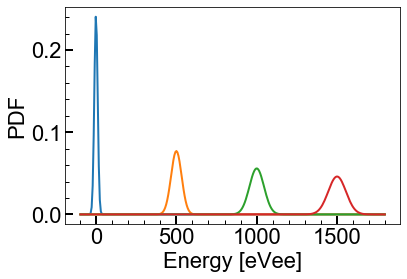

In [19]:
#Check resolution calculation
sigma0=10.27 #eV 
B=0.627*3.8 #This includes ER FANO, which we've already applied above
A=0 #TODO: This part has not been fit yet!
B_1=B-F*eps
Eb=np.linspace(-100,1800,300)
plt.plot((Eb[:-1]+Eb[1:])/2,gausInt(0, sigma_ee(0,sigma0,B_1,A),Eb[:-1],Eb[1:]));
plt.plot((Eb[:-1]+Eb[1:])/2,gausInt(500, sigma_ee(500,sigma0,B_1,A),Eb[:-1],Eb[1:]));
plt.plot((Eb[:-1]+Eb[1:])/2,gausInt(1000, sigma_ee(1000,sigma0,B_1,A),Eb[:-1],Eb[1:]));
plt.plot((Eb[:-1]+Eb[1:])/2,gausInt(1500, sigma_ee(1500,sigma0,B_1,A),Eb[:-1],Eb[1:]));
plt.gca().set_xlabel('Energy [eVee]');
plt.gca().set_ylabel('PDF');

np.sum(gausInt(1000, sigma_ee(1000,sigma0,B_1,A),Eb[:-1],Eb[1:]))

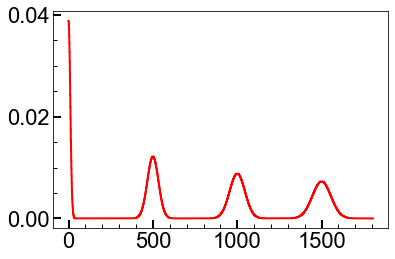

In [20]:
#Check applying detector resolution to a spectrum

Eb=np.arange(-0.5,1805,1) #If this goes too far negative, sigma breaks
Eb_ctr=(Eb[:-1]+Eb[1:])/2
Ec=np.zeros_like(Eb_ctr)
Ec[(Eb_ctr==0) | (Eb_ctr==500) | (Eb_ctr==1000) | (Eb_ctr==1500)]=1

Ec_smeared = Ec[:,np.newaxis]*gausInt(Eb_ctr[:,np.newaxis],sigma_ee(Eb_ctr[:,np.newaxis],sigma0,B_1,A),Eb[:-1],Eb[1:])
Ec_smeared_hist = np.sum(Ec_smeared,0)

#plt.step(Eb_ctr,Ec, where='mid',color='k', linestyle='-');
plt.step(Eb_ctr,Ec_smeared_hist, where='mid',color='r', linestyle='-');

In [21]:
def plotSpectra(E_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg, xrange=(0,1e3), yrange=(0,5e3), yscale='linear', thresh=None):
    fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
    ax1 = axes

    dE = E_bins[1]-E_bins[0]
    
    Ec = (E_bins[:-1] + E_bins[1:]) / 2
    
    ax1.step(Ec,N_nr, where='mid',color='k', linestyle='-', \
             label='NR, no Capture', linewidth=2)

    ax1.step(Ec,N_er, where='mid',color='r', linestyle='-', \
             label='ER, no Capture', linewidth=2)

    ax1.step(Ec,N_ng, where='mid',color='b', linestyle='-', \
             label='(n,gamma)', linewidth=2)

    ax1.step(Ec,N_nr+N_er+N_ng, where='mid',color='g', linestyle='-', \
             label='All Sims', linewidth=2)

    err = np.sqrt( N_PuBe/tlive_PuBe + N_bkg/tlive_bkg )
    ax1.errorbar(Ec,N_PuBe-N_bkg,yerr=[err,err], marker='o', markersize=6, \
                 ecolor='k',color='k', linestyle='none', label='Data-Bkg', linewidth=2)
    
    if thresh is not None:
        ax1.axvline(thresh, color='m', linestyle='--', linewidth=2, label='Threshold')
    
    ax1.set_yscale(yscale)
    ax1.set_xlim(*xrange)
    ax1.set_ylim(*yrange)
    ax1.set_xlabel('total deposited energy [eV$_{\\mathrm{ee}}$]',**axis_font)
    #ax1.set_ylabel('counts',**axis_font)
    ax1.set_ylabel('Events/bin/s',**axis_font)
    ax1.grid(True)
    ax1.yaxis.grid(True,which='minor',linestyle='--')
    ax1.legend(loc=1,prop={'size':22})

    for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)

    plt.tight_layout()

In [22]:
Eee_bins, Eee_hist_er_nocap, Eee_hist_nr_nocap, Eee_hist_ng, Eee_hist_PuBe, Eee_hist_Bkg = buildAvgSpectra([0.001,0.2,20], 0.1, 2e-2, doDetRes=True)

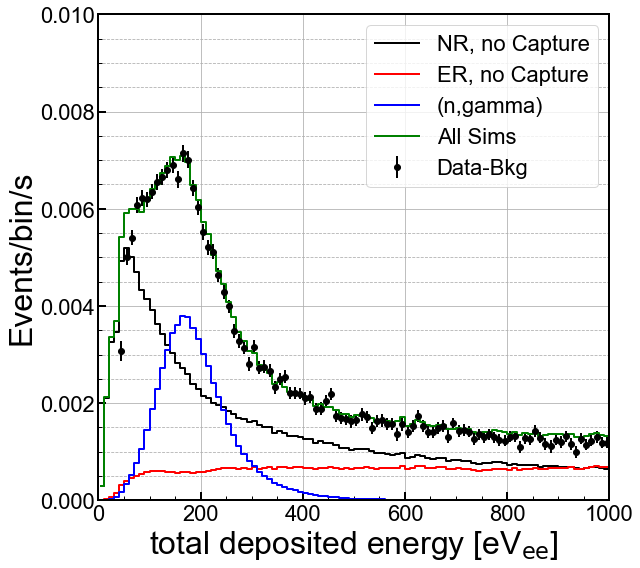

In [23]:
#plotSpectra(*buildSpectra([0.001,0.35,200], 0.5, 1e-2, doDetRes=True))
#print('===============')
#plotSpectra(*buildAvgSpectra([0.15,0.24,140], 2.4, fng_scale=1.5, fnrer_scale=1.5, doDetRes=True), yrange=(0,0.01))

plotSpectra(*buildAvgSpectra([0.178, 3e-4], 4.0, fng_scale=1.6, fnrer_scale=1.6, doDetRes=True), yrange=(0,0.01))

#plt.savefig("figures/R68_Y_fit/R68_Y_fit_Ytest2_1p5_tlive_detres.png")

In [24]:
#Compare average of spectra instances to analytitcal average
E_bins=list()
N_er=list()
N_nr=list()
N_ng=list()


for i in range(10):
    a,b,c,d,e,f = buildSpectra([0.178], 1, fng_scale=1.5, fnrer_scale=1.5, doDetRes=True);
    E_bins.append(a)
    N_er.append(b)
    N_nr.append(c)
    N_ng.append(d)
    
E_bins=np.array(E_bins)
N_er=np.array(N_er)
N_nr=np.array(N_nr)
N_ng=np.array(N_ng)

E_bins_avg, N_er_avg, N_nr_avg, N_ng_avg,_,_ = buildAvgSpectra([0.178], 1, fng_scale=1.5, fnrer_scale=1.5, doDetRes=True);

/home/phys/villaa/python/anaconda3_2019/envs/py373_gammapi/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/phys/villaa/python/anaconda3_2019/envs/py373_gammapi/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


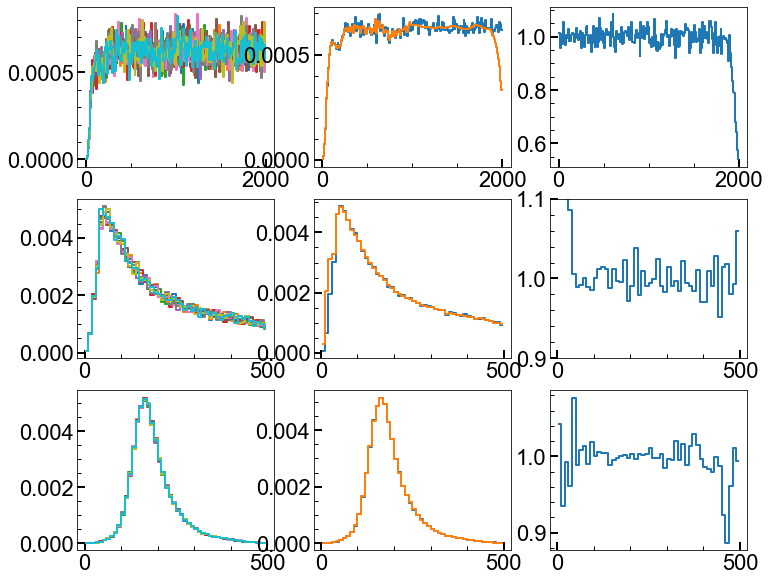

In [25]:
E_ctr=(E_bins[0][1:]+E_bins[0][:-1])/2

fig,ax = plt.subplots(3,3,figsize=(12.0,10.0),sharex=False)
for iN_er in N_er:
    ax[0,0].step(E_ctr,iN_er,where='mid');
ax[0,1].step(E_ctr,np.mean(N_er,0),where='mid');
ax[0,1].step(E_ctr,N_er_avg,where='mid');
ax[0,2].step(E_ctr,N_er_avg/np.mean(N_er,0),where='mid');

NRrange=slice(0,50)

for iN_nr in N_nr:
    ax[1,0].step(E_ctr[NRrange],iN_nr[NRrange],where='mid');
#ax[1,0].set_ylim(0,5e3)
#ax[1,0].set_yscale('log')
ax[1,1].step(E_ctr[NRrange],np.mean(N_nr,0)[NRrange],where='mid');
ax[1,1].step(E_ctr[NRrange],N_nr_avg[NRrange],where='mid');
#ax[1,1].set_ylim(0,5e3)
#ax[1,1].set_yscale('log')
ax[1,2].step(E_ctr[NRrange],(N_nr_avg/np.mean(N_nr,0))[NRrange],where='mid');
ax[1,2].set_ylim(0.9,1.1)

for iN_ng in N_ng:
    ax[2,0].step(E_ctr[NRrange],iN_ng[NRrange],where='mid');
ax[2,1].step(E_ctr[NRrange],np.mean(N_ng,0)[NRrange],where='mid');
ax[2,1].step(E_ctr[NRrange],N_ng_avg[NRrange],where='mid');
#ax[2,1].set_yscale('log')
ax[2,2].step(E_ctr[NRrange],(N_ng_avg/np.mean(N_ng,0))[NRrange],where='mid');

# Parameter Scan
All of the steps above got us to the point of comparing spectra. Let's define a goodness of fit quantity and then build a loop to fit for various parameters like those describing yield and NR Fano factor.

In [26]:
import scipy
#Chisq goodness of fit of spec_meas to spec_pred, given predicted uncertainties unc_pred
def Chisq(spec_meas, spec_pred, unc_pred):
    return ((spec_meas-spec_pred)**2)/(unc_pred**2)

#Calculate the Poissonian likelihood of measuring spectrum spec_meas given the predicted spectrum spec_pred
def PoisLikelihood(spec_meas, spec_pred):
    PLi = [np.exp(-lamb)*(float(lamb)**n)/scipy.math.factorial(n) for n,lamb in zip(spec_meas,spec_pred)]
    return np.prod(PLi)

#Calculate the Log of Poissonian likelihood of measuring spectrum spec_meas given the predicted spectrum spec_pred
def PoisLogLikelihood(spec_meas, spec_pred):
    #PLLi = [ -n*lamb-np.log(float(scipy.math.factorial(n)))+n*np.log(float(lamb)) for n,lamb in zip(spec_meas,spec_pred)]
    #Stirlings approx for large n
    PLLi = [ -n*lamb-n*np.log(n)-n+n*np.log(lamb) for n,lamb in zip(spec_meas,spec_pred)]
    return np.sum(PLLi)

In [27]:
#Main fitting functions which will be passed to minimizers
def FittingFunc(params):

    #Lindhard
    #Ypar0=params[0]
    #scale=params[1]
    #FNR=params[2]
    
    #E_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg = buildAvgSpectra([Ypar0], FNR, fng_scale=scale, fnrer_scale=scale, doDetRes=True)
    
    #Chavarria or #Sorensen with constant
    Ypar0=params[0]
    Ypar1=params[1]
    scale=params[2]
    FNR=params[3]
    E_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg = buildAvgSpectra([Ypar0,Ypar1], FNR, fng_scale=scale, fnrer_scale=scale, doDetRes=True)
    
    
    
    #Only evaluate bins from the range [bin_low,bin_high)
    bin_low=5
    bin_high=101
             
    spec_meas = (N_PuBe-N_bkg)[bin_low:bin_high]
    spec_pred = (N_er+N_nr+N_ng)[bin_low:bin_high]

    unc_meas = np.sqrt( N_PuBe/tlive_PuBe + N_bkg/tlive_bkg )[bin_low:bin_high]
    
    #return PoisLogLikelihood(spec_meas,spec_pred)
    return Chisq(spec_meas, spec_pred, unc_meas)

#As above, but returns the sum of chisq
def FittingFuncSum(params):
    return np.sum(FittingFunc(params))


In [28]:
#Scan over params
import time

start = time.time()
Nsample=20
ks=np.linspace(0.1,0.25,Nsample) #Lindhard k
scales=np.linspace(1,2,Nsample) #Simulation scale factor
X,Y=np.meshgrid(ks,scales)
Z=np.zeros_like(X)

for i,ki in enumerate(ks):
    print(np.round(10.0*i/Nsample),'%')
    for j,scalei in enumerate(scales):
        Z[j,i]=FittingFuncSum([ki,scalei])

end = time.time()
print((end - start)/60.,' min')

0.0 %


IndexError: list index out of range

In [ ]:
from matplotlib import ticker
import matplotlib.colors as colors
fig,ax = plt.subplots(1,2,figsize=(15.0,6.0))

cs0=ax[0].scatter(X, Y, c=Z, norm=colors.LogNorm(vmin=1e7, vmax=1e10))
ax[0].set_xlabel('k')
ax[0].set_ylabel('sim scale')
cbar0=plt.colorbar(cs0, ax=ax[0])
cbar0.set_label('Chisq', rotation=270)


cs1=ax[1].contourf(X,Y,Z,norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()), levels=np.logspace(7,10,13))
ax[1].set_xlabel('k')
ax[1].set_ylabel('sim scale')
cbar1=plt.colorbar(cs1, ax=ax[1])
cbar1.set_label('Chisq', rotation=270)

ax[1].axhline(1.60529231,color='r',linestyle='--')
ax[1].axvline(0.18041768,color='r',linestyle='--')

plt.tight_layout()
#plt.savefig("figures/R68_Y_fit/scan_2_chisq_wfit.png")

In [ ]:
imin=np.unravel_index(np.argmin(Z, axis=None), Z.shape)
print(X[imin], Y[imin])

In [ ]:
plotSpectra(*buildAvgSpectra([X[imin]], 2.4, fng_scale=Y[imin], fnrer_scale=Y[imin], doDetRes=True), yrange=(0,0.01), thresh=50)
#plt.savefig("figures/R68_Y_fit/scan_2_best_spectrum.png")

In [ ]:
#These are expensive scans. Let's save the results
import pickle as pkl
import os

saveScan=False

if saveScan:
    ifile = 0
    while os.path.exists('data/R68_Y_fit/scan_{}.pkl'.format(ifile+1)):
        ifile += 1
        
    print('data/R68_Y_fit/scan_{}.pkl'.format(ifile+1))
    scanFile = open('data/R68_Y_fit/scan_{}.pkl'.format(ifile+1), 'wb')
    pkl.dump(X, scanFile)
    pkl.dump(Y, scanFile)
    pkl.dump(Z, scanFile)
    scanFile.close()

# Fitting Functions
Instead of scanning the parameter space, use a minimizer to find the best fit params

First, try mimize

In [ ]:
from scipy.optimize import minimize

#Lindhard
#x0=[0.15, 1.2, 2.4]  #k, sim_scale, F_NR
#bounds=((0,1),(0,10),(0,5))

#Chavarria
#x0=[0.15, 0.2, 1.2, 2.4]  #k, a, sim_scale, F_NR
#bounds=((0,1),(1./1000,1./0.1),(0,10),(0,5))

#Sorensen with constant
x0=[0.15, 1e-4, 1.2, 2.4]  #k, q, sim_scale, F_NR
bounds=((0,1),(0,1e-3),(0,10),(0,5))

start = time.time()
res = minimize( FittingFuncSum, x0, bounds=bounds )
end = time.time()
print('{0:.1f} minutes'.format((end - start)/60.))

print(res)

In [ ]:
#Estimate parameter variances
#Inverse of hessian is unscaled covariance matrix (https://e-maxx.ru/bookz/files/numerical_recipes.pdf)
#Follow the perscription here to rescale it (https://stackoverflow.com/questions/43593592/errors-to-fit-parameters-of-scipy-optimize)

ftol = 2.220446049250313e-09
res.err=np.sqrt(max(1, abs(res.fun))*ftol*np.diag(res.hess_inv.todense()))

#Lindhard
par_names=["k","sim_scale","F_NR"]
#Chavarria
#par_names=["k","a","sim_scale","F_NR"]
for i,j,k in zip(par_names,res.x,res.err):
    print("{0} = {1:.3f} +/- {2:.4e}".format(i,j,k))
    

In [ ]:
#Lindhard
#plotSpectra(*buildAvgSpectra([res.x[0]], res.x[2], fng_scale=res.x[1], fnrer_scale=res.x[1], doDetRes=True), 
#            xrange=(0,1e3), yrange=(0,0.01), thresh=50)
#plt.savefig("figures/R68_Y_fit/fit_Lind1_spectrum.png")

#Chavarria
#plotSpectra(*buildAvgSpectra([res.x[0],res.x[1]], res.x[3], fng_scale=res.x[2], fnrer_scale=res.x[2], doDetRes=True), 
#            xrange=(0,1e3), yrange=(0,0.01), thresh=50)
#plt.savefig("figures/R68_Y_fit/fit_Chav1_spectrum.png")

In [ ]:
#Plot the best-fit yield models
#Also histogram the NR energies we used so we can see where we probed Y

#From python/damic_y.py
import dataPython as dp #Anthony's text file library
damic_data = dp.getXYdata_wXYerr('data/DAMIC_siyield_allerr.txt')
#convert to numpy arrays
damic_data['xx']= np.asarray(damic_data['xx'])*1000 #make units eV
damic_data['yy']= np.asarray(damic_data['yy'])*1000 #make units eV
damic_data['ex']= np.asarray(damic_data['ex'])*1000 #make units eV
damic_data['ey']= np.asarray(damic_data['ey'])*1000 #make units eV

#get the yield stuff
damic_data['yy_yield'] = damic_data['yy']/damic_data['xx']
damic_data['ey_yield'] = damic_data['yy_yield'] * np.sqrt((damic_data['ey']/damic_data['yy'])**2 + 
                                                          (damic_data['ex']/damic_data['xx'])**2)

#Some Fit results
popt_lind=[0.178, 1.619, 4.092]
perr_lind=[4.9156e-04, 1.1264e-04, 2.8346e-03]

popt_chav=[0.221, 0.003, 1.699, 4.389]
perr_chav=[0.012, 0.001, 0.011, 0.108]


fig,ax = plt.subplots(2,2,figsize=(12.0,8.0),sharex=True)
Er_plt=np.linspace(0,3e3,1000)

ax[0,0].errorbar(damic_data['xx'],damic_data['yy'],yerr=[damic_data['ey'], damic_data['ey']],
               marker='o', linestyle='none', markersize=6, linewidth=2 ,label='Damic Points')

ax[0,0].plot(Er_plt,Er_plt*yL(Er_plt,popt_lind[0]),label='Lindhard, k={0:.3f}'.format(popt_lind[0]))
#ax[0,0].fill_between(Er_plt,Er_plt*yL(Er_plt,popt_lind[0]-perr_lind[0]),
#                     Er_plt*yL(Er_plt,popt_lind[0]+perr_lind[0]),color='C1',alpha=0.5)

ax[0,0].plot(Er_plt,Er_plt*yChav(Er_plt,popt_chav[0],popt_chav[1]),
             label='Chavarria, k={0:.3f}, a={1:.3f}'.format(popt_chav[0],popt_chav[1]))

ax[0,0].set_xlabel(r'$E_{recoil}$ [eV]')
ax[0,0].set_ylim(0,1000)
ax[0,0].set_ylabel(r'$E_{Ion}$ [eV]')
ax[0,0].legend()

ax[1,0].errorbar(damic_data['xx'],damic_data['yy_yield'],yerr=[damic_data['ey_yield'], damic_data['ey_yield']],
               marker='o', linestyle='none', markersize=6, linewidth=2 ,label='Damic Points')
ax[1,0].plot(Er_plt,yL(Er_plt,popt_lind[0]),label='Lindhard, k={0:.3f}'.format(popt_lind[0]))
#ax[1,0].fill_between(Er_plt,yL(Er_plt,popt_lind[0]-perr_lind[0]),yL(Er_plt,popt_lind[0]+perr_lind[0]),color='C1',alpha=0.5)
ax[1,0].plot(Er_plt,yChav(Er_plt,popt_chav[0],popt_chav[1]),label='Chavarria, k={0:.3f}, a={1:.3f}'.format(popt_chav[0],popt_chav[1]))

ax[1,0].set_xlabel(r'$E_{recoil}$ [eV]')
ax[1,0].set_ylabel('Y')


Ebins=np.arange(1,3001,20)
ax[0,1].hist(evec_nr_nocap.flatten(),alpha=0.5,bins=Ebins,label='Direct NR')
ax[0,1].hist(cdata['E'][cdata['cEscape']].flatten(),alpha=0.5,bins=Ebins,label='E, (n,g)')
ax[0,1].hist((cdata['E'][cdata['cEscape']]-cdata['delE'][cdata['cEscape']]).flatten(),alpha=0.5,bins=Ebins,label='E-dE, (n,g)')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel(r'$E_{recoil}$ [eV]')
ax[0,1].set_ylabel('Counts')
ax[0,1].legend()
plt.tight_layout()
#plt.savefig('figures/R68_Y_fit/Yfit_3.png')

In [ ]:
np.mean(evec_nr_nocap.flatten())

# Playground
Stuff below here is in alpha stage
=========================================
=========================================


In [ ]:
#A redifinition of the fitting function for use with lmfit
def FittingFunc_v2(params,x=None):
    parvals = params.valuesdict()
    Y = parvals['Y']
    F_NR = parvals['F_NR']
    fudge = parvals['fudge']
    
    E_bins, N_er, N_nr, N_ng, N_PuBe, N_bkg = buildSpectra(Y, F_NR, fudge)
    
    thresh_bin=5
    
    spec_meas = (N_PuBe-N_bkg)[thresh_bin:]
    spec_pred = (N_er+N_nr+N_ng)[thresh_bin:]
    unc_pred = np.sqrt(spec_pred)
    
    #return PoisLogLikelihood(spec_meas,spec_pred)
    #return Chisq(spec_meas, spec_pred, unc_pred)
    return ((spec_meas-spec_pred)**2)/(unc_pred**2)

In [ ]:
# Try with lmfit
import lmfit

# create a set of Parameters
params = lmfit.Parameters()
params.add('Y', value=0.8, min=0, max=1)
params.add('F_NR', value=3, min=0, max=10)
params.add('fudge', value=8e-3, vary=False, min=0, max=1e-1)

# do fit, here with leastsq model
minner = lmfit.Minimizer(FittingFunc_v2, params, epsfcn=0.1)
result = minner.minimize()
print(lmfit.fit_report(result))

# Integral Method
As discussed in the Damic NR Yield paper, another approach is to compare the integrals of the simulated and measured spectra to obtain Y. This does not rely on a parameterized yield function. However, applying resolution and Fano effects are tricky.

TODO: Where does Fano fit in here?

How to account for multiple recoils in capture events?

Steps
1. Calculate normalization factor so Simulated ER spectrum agrees with Measured, bkg-subtracted spectrum above ~1.75 keV. We'll use the same factor for simulated NRs too. Somehow normalize (n,gamma) spectrum as well.
2. Starting at the high energy end, count the number of measured events above electron-equivalent energy Ee_star, Ne_meas(Ee>Ee_star). Then find the nuclear recoil energy, Er_star such that: Ner_sim(Ee>Ee_star) + Nnr_sim(Er>Er_star)= Ne_meas(Ee>Ee_star). This will result in a set of points (Er_star,Ee_star) which define Y.
3. Apply the calculated Y to the Simulated spectra, then smear it with the detector resolution, and use Y to convert back to nuclear recoil energies. Finally, repeat the steps in 2) to obtain Y from the smeared Simulated spectrum.
4. Repeat the above steps, starting with the original unsmeared spectrum and the new Y.
5. Continue this all until Y converges.

In [ ]:
y=Yield(evec_nr_nocap,[0.15,0.24,140])
print(y)
print(np.where(evec_nr_nocap>0,y,0))

In [ ]:
Eos=np.linspace(0,1,10)
s=1.0*((Eos>0.5) & (Eos<0.7))
print(s,np.equal(s,0,dtype=float),(~np.equal(s,0,dtype=float))*s)
print(gausInt(1,0,0.5,1.5))

In [ ]:
###Try to figure out why the (n,gamma) calculations don't agree
E_ng = cdata['E'][cdata['cEscape']]
dE_ng = cdata['delE'][cdata['cEscape']]
E_ng_er = E_ng*Yield(E_ng,[0.15]) - (E_ng-dE_ng)*Yield(E_ng-dE_ng,[0.15])

In [ ]:
#The one-off way, many times for a single event
#def getNeh(E,eps,F):
#    N=np.random.normal((E/eps),np.sqrt(F*(E/eps)),np.shape(E))
#    return np.maximum(0,N)

Etest=E_ng[0]
dE_test=dE_ng[0]
Eer_test=E_ng_er[0]

N_test = np.array([getNeh(Eer_test,eps,2.4) for i in range(100000)])

Etv_test = N_test*V + dE_test
Et_test = np.sum(Etv_test,1)

#convert to eVee scale by making the gamma assumption
Eee_test  = Et_test/G_NTL

print(np.mean(N_test[:,0]),np.sum(Eer_test)/eps,np.std(N_test[:,0]),np.sqrt(2.4*Eer_test[0]/eps))
print(np.mean(Eee_test),np.sum(dE_test + Eer_test/eps*V)/G_NTL,np.std(Eee_test),np.sqrt(np.sum(2.4*Eer_test/eps*V**2/((1+V/eps)**2))))


In [ ]:
#Now the average way
AEeeVec_test = (dE_test + Eer_test*V/eps) / (1+V/eps)#Electon-equivalent
AEeeMean_test = np.sum(AEeeVec_test)

SigmaEeeSq_test = Eer_test*(V**2)*2.4/eps/((1 + V/eps)**2)
SigmaEee_test = np.sqrt(np.sum(SigmaEeeSq_test))  

print(SigmaEee_test)

#Reshape so we can broadcast against bin centers
#AEeeMean_test = AEeeMean_test[:,np.newaxis]
#SigmaEee_test = SigmaEee_test[:,np.newaxis]

#E_ee binning
Eee_max = 500 #eVee
Nbins_Eee = 50
Eee_bins = np.linspace(0,Eee_max,Nbins_Eee+1)#bin edges

#Weighted spectra of Eee energies measured
Eee_counts_test = 100000*gausInt(AEeeMean_test, SigmaEee_test, Eee_bins[:-1], Eee_bins[1:])
np.sum(gausInt(AEeeMean_test, SigmaEee_test, Eee_bins[:-1], Eee_bins[1:]))

In [ ]:
plt.figure()
plt.hist(Eee_test,bins=Eee_bins)
plt.step((Eee_bins[:-1]+Eee_bins[1:])/2,Eee_counts_test,where='mid', linestyle='-')
#The rounding seems to make the difference in structure for 1 event.

In [ ]:
Eee_max = 2000 #eVee
Nbins_Eee = 200
Eee_bins = np.linspace(0,Eee_max,Nbins_Eee+1)#bin edges

In [ ]:
Eee_bins